## Проект: вариант 2

### Задание 1. A/B–тестирование

##### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

##### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль,  B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

##### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

##### 1.4 Требования к ответу

* При выполнении тестового задания необходимо использовать язык программирования Python. 
* В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
* Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.stats.proportion as proportion
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import chi2

import requests 
from urllib.parse import urlencode

from matplotlib.pyplot import figure

In [2]:
#Выгружаем данные с сайтов

def get_url(link: str) -> str:
    # используем api 
    my_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # получаем url 
    url = my_url + urlencode(dict(public_key = link)) 
    response = requests.get(url) 
    url = response.json()['href'] 
    return url

groups = pd.read_csv(get_url('https://disk.yandex.ru/d/58Us0DWOzuWAjg'), sep=';')
group_add = pd.read_csv(get_url('https://disk.yandex.ru/d/3aARY-P9pfaksg'), sep=',')
studs = pd.read_csv(get_url('https://disk.yandex.ru/d/prbgU-rZpiXVYg'), sep=';')
checks = pd.read_csv(get_url('https://disk.yandex.ru/d/84hTmELphW2sqQ'), sep=';')

In [3]:
#Так как в данных разые названия колонок с id, приведем их к единообразию

studs = studs.rename(columns = {'student_id':'id'})
checks = checks.rename(columns = {'student_id':'id'})

In [4]:
#проверим распределение пользователей по группам. В тестах неудачное распределение по группам, так как для корректного 
#проведения а/б тестирования, в контрольной и тестовой группе должны быть примерно равные по размерам выборки

print(groups.query("grp=='A'").id.count())
print(groups.query("grp=='B'").id.count())

14671
59813


In [5]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [6]:
#Для начала выделим именно активных пользователей, дополнительные данные group_add пока не будем использовать, применим их
#позже и посмотрим, измениться ли что-то от этого

stud_active = groups.merge(studs, how = 'inner', on = 'id')
stud_active

,id,grp
0,1627,A
1,2085,B
2,2215,B
3,3391,A
4,3401,B
...,...,...
8323,5681918,B
8324,5685258,B
8325,5688310,B
8326,5689627,B


In [7]:
#Посмотрим все ли активные пользователи нормально смерджились

studs.shape

(8341, 1)

In [8]:
stud_active.shape

(8328, 2)

In [9]:
#Получается, что 13 активных пользователей, вообще не попали в эксперимент, видимо для был дан доп. файл с данными, посмотрим 
#на него позже. Теперь объединим полученный датафрейм и данные по оплатам, и проверим, все ли оплаты смерджились

paid_studs = stud_active.merge(checks, how = 'inner', on = 'id')
paid_studs.shape

(391, 3)

In [10]:
checks.shape

(541, 2)

In [11]:
#Вновь видим, что не все чеки попали в конечную таблицу.
#Теперь смерджим оплативших студентов с дф с группами

paid_groups = groups.merge(checks, how = 'inner', on = 'id')
paid_groups.shape

(540, 3)

In [12]:
#ПОлучается, что 149 пользователей попали в экперимент, оплатили, но не считаются активными.
#Так как данных о сайте, то можно предположить, что на сайте оформляется подписка/покупка или что-то подобное, которая списалась  
#у данных пользователей в это время, но активными они не были
#Неактивные пользователи вряд ли смогли оценить нововведение, поэтому будем анализировать только активных пользователей

Для начала решим, какие метрики мы будем оценивать. У нас есть кол-во пользователей в каждой группе, кол-во активных пользователей, количество покупок и чеки. Для начала оценим конверсию в покупку и средний чек. Так как в таблицах нет других данных, то выберем именно эти метрики, так как они лежат в основе других более сложных метрик Также имнно эти метрики являются базовыми в бизнесе. Посмотрим есть ли стат. значимые различия в этих метриках, затем посмотрим нужно ли будет оценивать ARPPU, ARPU.

* CR = сумма клиентов/сумма пользователей                                                                                   
* av_check = доход/число покупок

Сначала разделим данные на тест и контроль. Также проверим, есть ли пользователи которые оплатили товар или услугу дважды

In [13]:
#Посмотрим сколько строк в paid_studs и paid_groups и сколько уникальных пользователей, чтобы узнать, 
#могут ли быть повторные покупки

paid_studs.shape

(391, 3)

In [14]:
paid_studs.nunique()

id     391
grp      2
rev     38
dtype: int64

In [15]:
paid_groups.shape

(540, 3)

In [16]:
paid_groups.nunique()

id     540
grp      2
rev     39
dtype: int64

In [17]:
#Для всех данных отсортируем пользователей по группам

stud_active_a = stud_active.query('grp=="A"')

stud_active_b = stud_active.query('grp=="B"')

paid_studs_a = paid_studs.query('grp=="A"')

paid_studs_b = paid_studs.query('grp=="B"')

paid_groups_a = paid_groups.query('grp=="A"')

paid_groups_b = paid_groups.query('grp=="B"')

groups_a = groups.query('grp=="A"')

groups_b = groups.query('grp=="B"')

In [18]:
#Посчитаем конверсию
CR_a = paid_studs_a.shape[0]/stud_active_a.shape[0]
CR_b = paid_studs_b.shape[0]/stud_active_b.shape[0]
print(CR_a)
print(CR_b)

0.050814332247557006
0.04607684380980421


In [19]:
#Посчитаем средний чек
av_check_a = paid_studs_a.rev.sum()/paid_studs_a.shape[0]

av_check_b = paid_studs_b.rev.sum()/paid_studs_b.shape[0]

print(av_check_a)
print(av_check_b)

933.5897435897435
1255.8274872204472


На первый взгляд данные метрики разных групп отличаются, но это пока догадки, посмотрим на графики  распределений чеков и проверим данные на нормальность.

In [20]:
paid_studs_a.rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [21]:
paid_studs_b.rev.describe()

count     313.000000
mean     1255.827487
std       791.293377
min       199.000000
25%       489.000000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

C:\Users\anna1\AppData\Local\Temp\ipykernel_9676\2967005715.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_plot = sns.distplot(paid_studs_a['rev'], color = 'red')


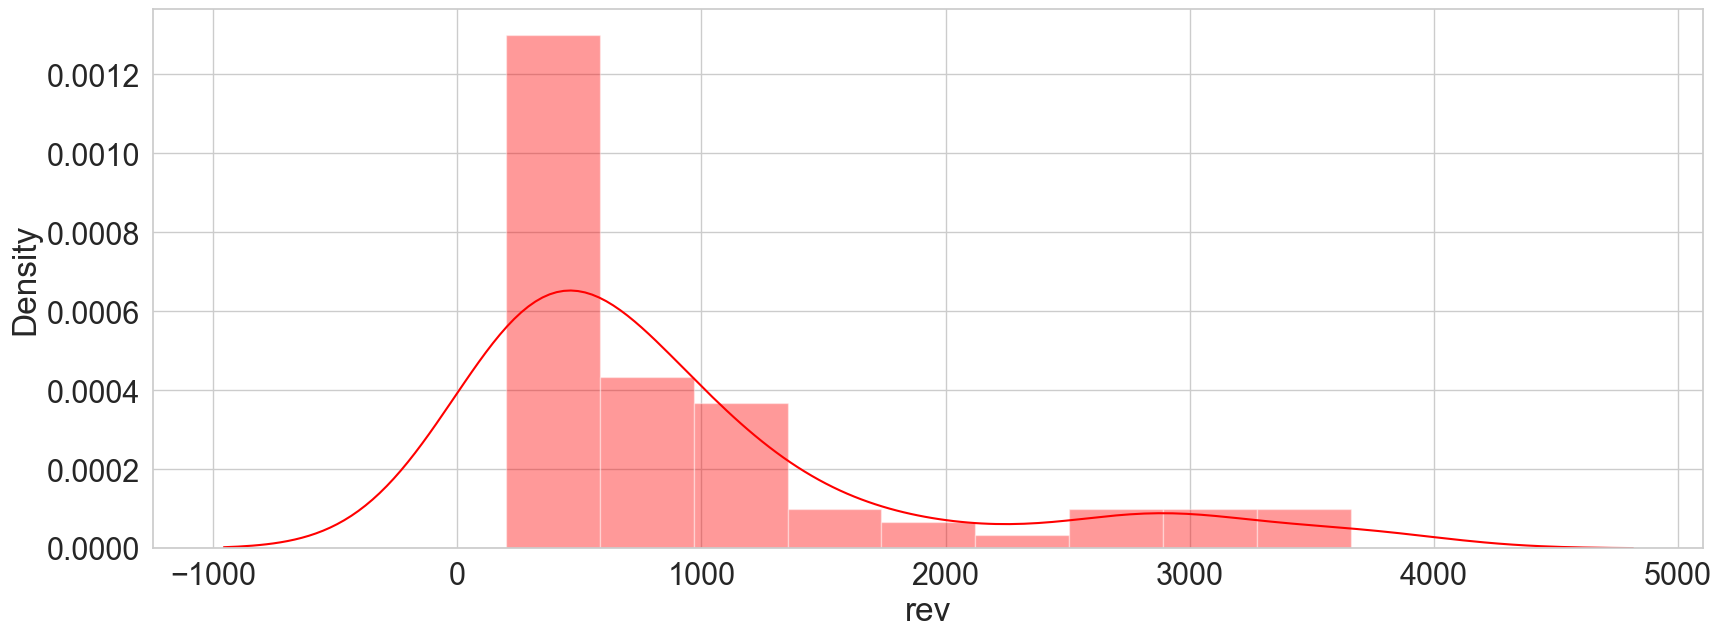

C:\Users\anna1\AppData\Local\Temp\ipykernel_9676\2967005715.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_plot = sns.distplot(paid_studs_b['rev'], color = 'blue')


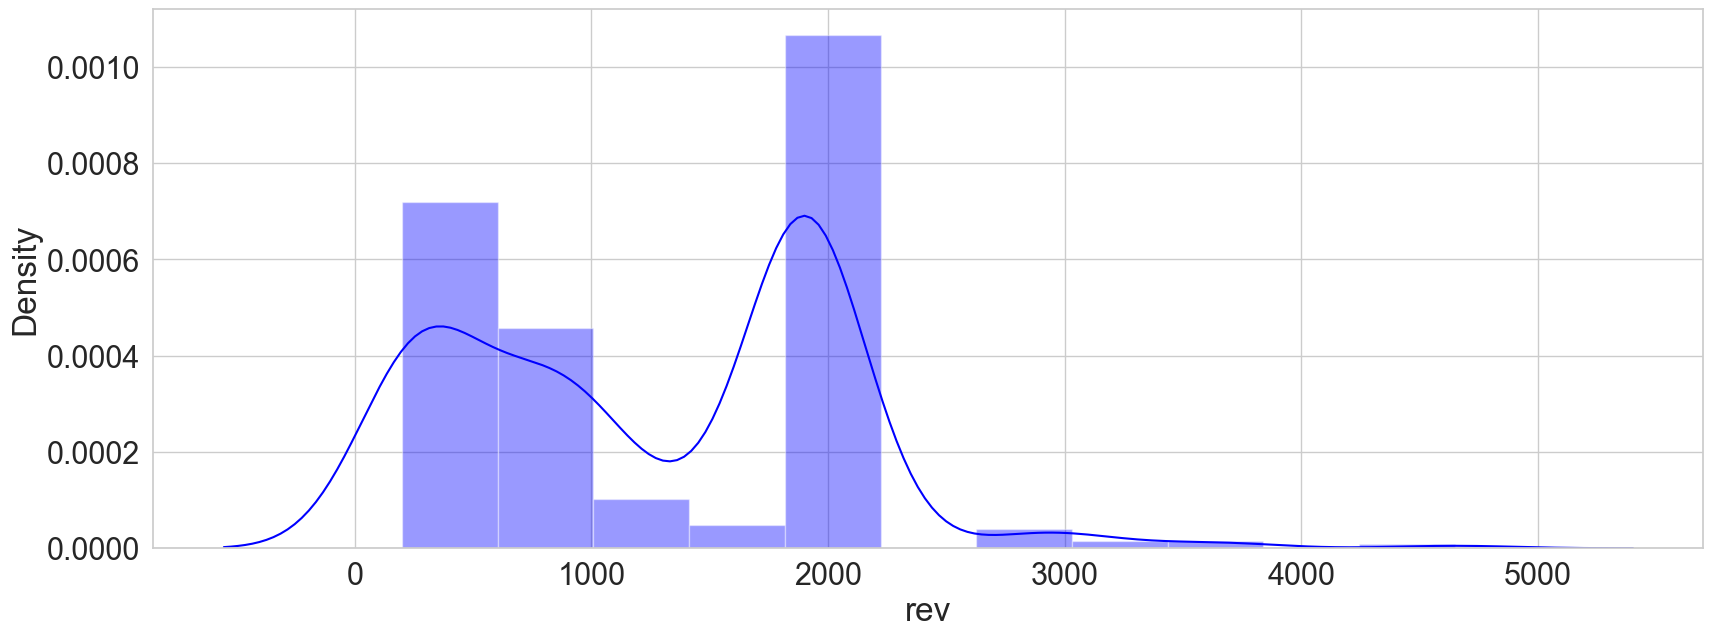

In [22]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

sns_plot = sns.distplot(paid_studs_a['rev'], color = 'red')
plt.show()

sns_plot = sns.distplot(paid_studs_b['rev'], color = 'blue')
plt.show()


Также судя по описательной статитстике и графикам распределенйи для контрольной группы окло 75% чеков менее 1100, но в тестовой группе возможно случился некоторый сбой и 50% чеков превышают порог в 1000.

Судя по графикам, распределение не нормальное, но проверим еще это с помощью теста Шапиро-Уилкса. Уровень значимости значительно ниже 0,05, что еще раз подтверждает, что в группах чеки распределены не нормально. Теперь проверим есть ли все-таки статистически значимые различия в указанных выше метриках.

Конверсия это биноминальная метрика, то есть пользователь либо сконевертировался в покупку (1), либо нет (0), здесь нет какой-то количественной оценки, это две категориальные переменные, поэтому будем использовать Хи-квадрат

H0: различий между переменными нет
H1:  между переменными есть сат. значимые различия

In [23]:
stats.shapiro(paid_studs_a['rev'])

ShapiroResult(statistic=0.7353235483169556, pvalue=1.4986777097103499e-10)

In [24]:
stats.shapiro(paid_studs_b['rev'])

ShapiroResult(statistic=0.8551955223083496, pvalue=1.7560165607818e-16)

Подготовим данные для хи-квадрата, составим таблицу, где будет для каждой группы, количество клиентов, пользователей, конверсия и доход общий

In [25]:
#Рассчитаем  общий доход, кол-во клиентов
rev_clients = paid_studs.groupby('grp', as_index = False)\
    .agg({'rev':'sum', 'id':'nunique'})\
    .rename(columns={'rev':'sum_rev', 'id':'clients'})
rev_clients

,grp,sum_rev,clients
0,A,72820.0000,78
1,B,393074.0035,313


In [26]:
#Расчитаем количество чеков
count_ch = paid_studs.groupby('grp', as_index = False)\
    .agg({'rev':'count'})\
    .rename(columns={'rev':'count_checks'})
count_ch

,grp,count_checks
0,A,78
1,B,313


In [27]:
df = rev_clients.merge(count_ch, how = 'inner', on = 'grp')
df

,grp,sum_rev,clients,count_checks
0,A,72820.0000,78,78
1,B,393074.0035,313,313


In [28]:
#Расчитаем количество активных пользователей
active = stud_active.groupby('grp', as_index = False)\
    .agg({'id':'nunique'})\
    .rename(columns={'id':'active'})
active

,grp,active
0,A,1535
1,B,6793


In [29]:
df = df.merge(active, how = 'inner', on = 'grp')
df

,grp,sum_rev,clients,count_checks,active
0,A,72820.0000,78,78,1535
1,B,393074.0035,313,313,6793


In [30]:
#Рассчитаем общее кол-во пользователей в группах
grp = groups.groupby('grp', as_index = False)\
    .agg({'id':'nunique'})\
    .rename(columns={'id':'users'})
grp

,grp,users
0,A,14671
1,B,59813


In [31]:
df = df.merge(grp, how = 'inner', on = 'grp')
df

,grp,sum_rev,clients,count_checks,active,users
0,A,72820.0000,78,78,1535,14671
1,B,393074.0035,313,313,6793,59813


In [32]:
#Расчитаем метрики
df['CR'] = round(df.clients / df.active*100, 4)

df['av_ch'] = df.sum_rev / df.count_checks

df['ARPPU'] = df.count_checks / df.clients * df.av_ch

df['ARPU'] = df.sum_rev / df.users

df

,grp,sum_rev,clients,count_checks,active,users,CR,av_ch,ARPPU,ARPU
0,A,72820.0000,78,78,1535,14671,5.0814,933.589744,933.589744,4.963534
1,B,393074.0035,313,313,6793,59813,4.6077,1255.827487,1255.827487,6.571715


In [33]:
#Тест Хи-квадрат для конверсии в покупку

chi2stat, pval, table = proportion.proportions_chisquare(df.clients, df.active)
print(pval)

0.4280822964525912


Значение p-value, поможет оценить: есть ли статистическая значимость в разнице между группами А и В в конверсии. Порог значимости альфа в нашем случае 0,05. В данном случае уровень значимости p-value = 0,428 выше, чем альфа, поэтомы мы не можем отклонить Н0,  различия в конверсиях между группами не являются  стат. значимыми

Теперь рассмотрим метрику - средний чек. Так как распределение не нормальное, то мы можем применить либо критерий Манна-Уитни, либо бутстрап.
Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки. 
Нам больше подойдет бутстрап

In [34]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

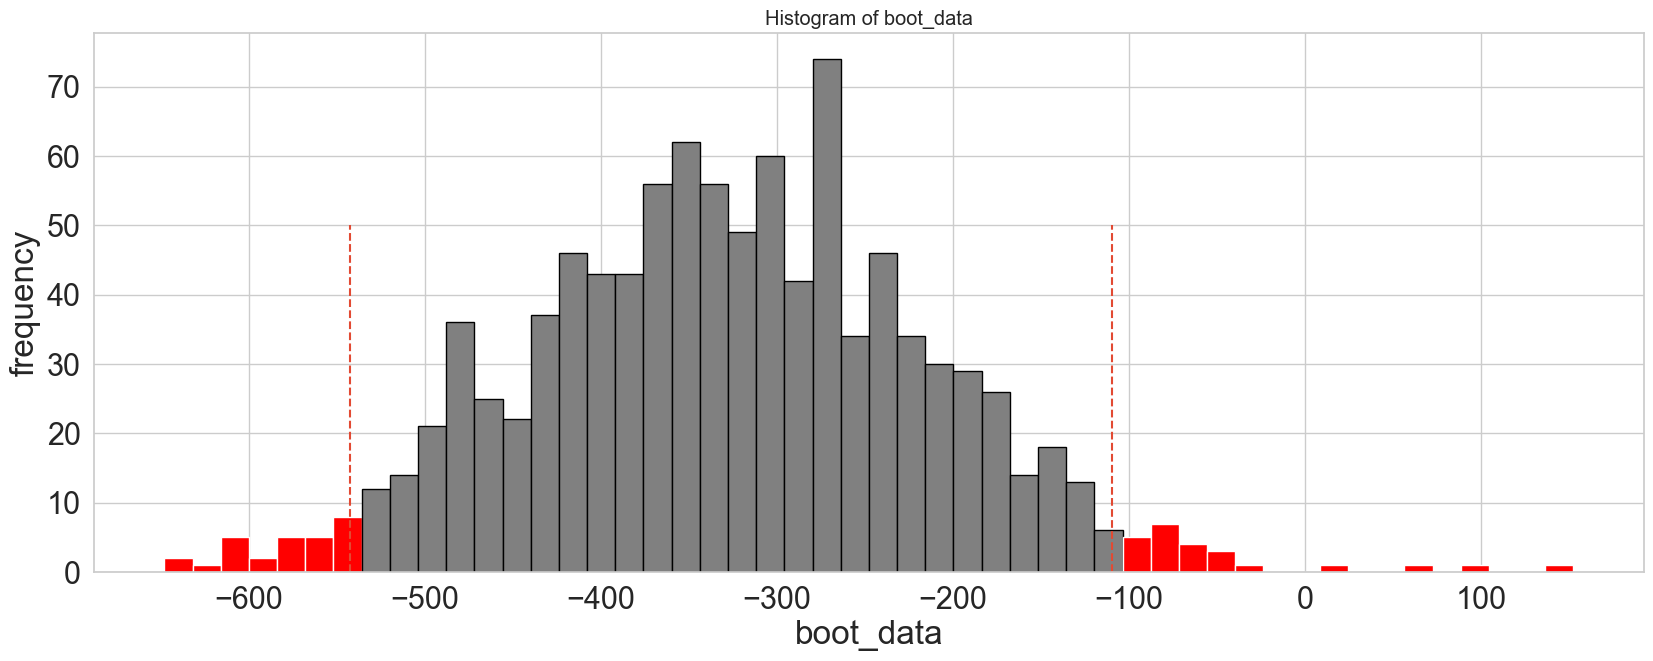

{'p_value': 0.003810530697674391}

In [35]:
get_bootstrap(
    paid_studs_a['rev'], # числовые значения первой выборки
    paid_studs_b['rev'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Тут история немного другая, p-value значительно меньше уровня 0,05 и в среднем чеке есть стат. значимые различия

На данный момент у нас проанализированы две метрики, которые являются самыми важными в бизнесе. 
Также по данным мы можем оценить ARPU и ARPPU, посмотрим на формулы

* ARPPU=Число повторных покупок * Средний чек = Число покупок/Число клиентов * Средний чек                                 
* ARPU=Конверсия * ARPPU = Конверсия * avg_ch

Рассмотрим данную часть формулы Число покупок/Число клиентов
Также ARPU это доход с привлеченного пользователя
То есть эта часть равна 1 и значит, что 

* ARPPU=Число повторных покупок * Средний чек = avg_ch                                         
* ARPU = Доход/Число пользователей

Значит метрику ARPPU можно не проверять стат. тестами, остается только ARPU, то есть средний доход на пользователя, распределение ненормальное и большие различия в выборках подталкивают снова к бустрепу, только подготовим данные/


In [36]:
#Рассмотрим данную часть формулы Число покупок/Число клиентов
checks.id.nunique()/checks.rev.count()

1.0

In [37]:
paid_studs_arpu_1 = groups.merge(paid_studs, how = 'left', on = ['id', 'grp']) 
paid_studs_arpu_1

,id,grp,rev
0,1489,B,NaN
1,1627,A,990.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN
...,...,...,...
74479,5692459,B,NaN
74480,5692572,B,NaN
74481,5692865,B,NaN
74482,5693667,B,NaN


In [38]:
paid_studs_arpu = paid_studs_arpu_1.fillna(0)

paid_studs_arpu_a = paid_studs_arpu.query('grp=="A"')

paid_studs_arpu_b = paid_studs_arpu.query('grp=="B"')

  0%|          | 0/1000 [00:00<?, ?it/s]

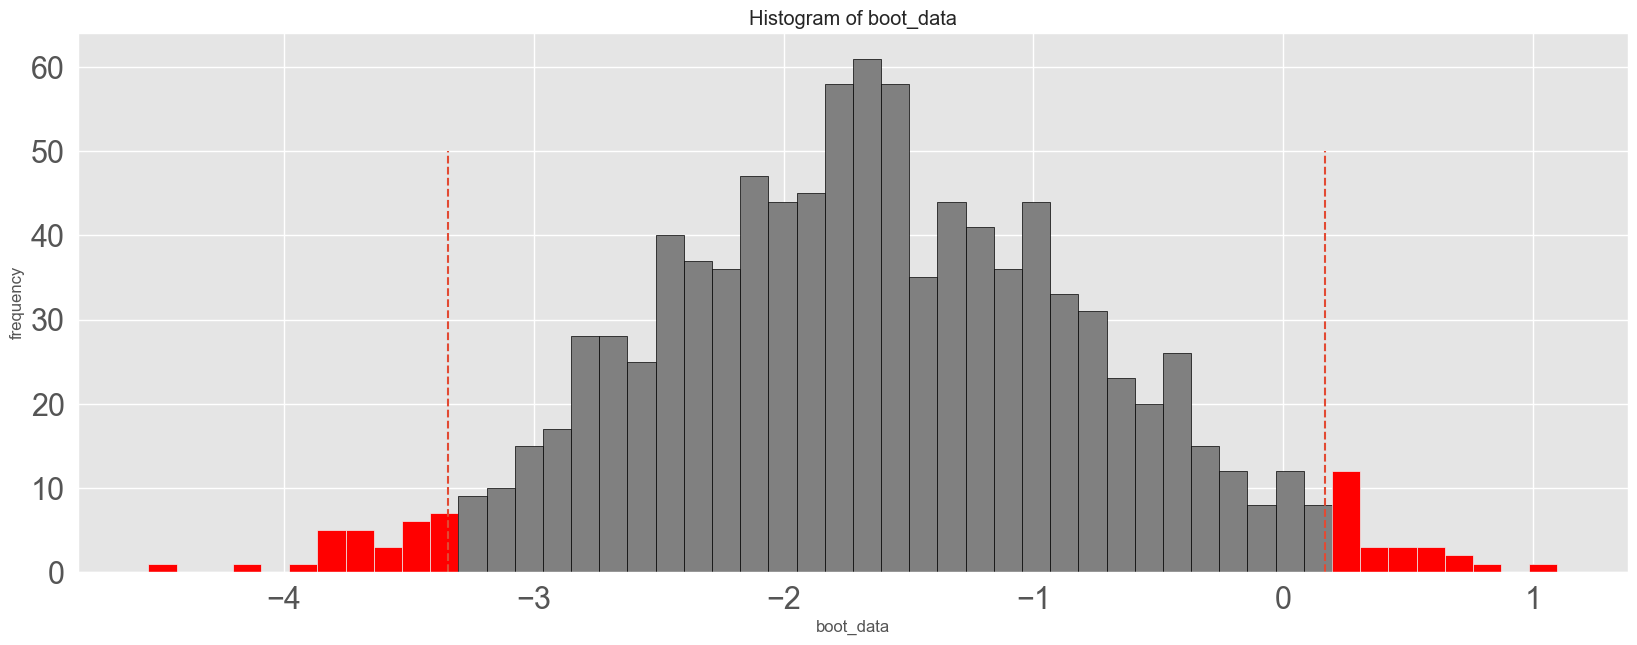

{'p_value': 0.06613407096977394}

In [39]:
get_bootstrap(
    paid_studs_arpu_a['rev'], # числовые значения первой выборки
    paid_studs_arpu_b['rev'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Бутстрап в случае сравнений метрики ARPU показал, что метрики ARPU для разных групп при данных условиях и в данных  выборках не отличаются стат. значимо.  
Теперь сделаем все те же, действия, что и ранее, но добавим к данным groups данные group_add и посмотрим изменится ли что-то.

In [40]:
#Проверим, не попались ли одинаковые id в таблицах group_add и groups
groups.merge(group_add, how = 'inner', on = 'id')

#совпадающих id нет

,id,grp_x,grp_y


In [41]:
#Смерджим данные 
groups = groups.merge(group_add, how = 'outer', on = ['id', 'grp']).fillna(0)

In [42]:
#С объединением таблиц размеры выборок практически не изменились, и все также очень сильно различаются.
print(groups.query("grp=='A'").id.count())
print(groups.query("grp=='B'").id.count())

14693
59883


In [43]:
#Для начала выделим именно активных пользователей, но теперь у нас все активные пользователи есть в таблице
stud_active = groups.merge(studs, how = 'inner', on = 'id')
stud_active

,id,grp
0,1627,A
1,2085,B
2,2215,B
3,3391,A
4,3401,B
...,...,...
8336,5760471,B
8337,5777081,B
8338,5870856,A
8339,5945085,B


In [44]:
#Теперь объединим полученный датафрейм и данные по оплатам, и проверим, все ли оплаты смерджились. Но 149 пользователей из
#оплативших так и остались не активными

paid_studs = stud_active.merge(checks, how = 'inner', on = 'id')
paid_studs.shape

(392, 3)

In [45]:
#Вновь видим, что не все чеки попали в конечную таблицу.
#Теперь смерджим оплативших студентов с дф с группами

paid_groups = groups.merge(checks, how = 'inner', on = 'id')
paid_groups.shape

(541, 3)

In [46]:
stud_active_a = stud_active.query('grp=="A"')

stud_active_b = stud_active.query('grp=="B"')

paid_studs_a = paid_studs.query('grp=="A"')

paid_studs_b = paid_studs.query('grp=="B"')

paid_groups_a = paid_groups.query('grp=="A"')

paid_groups_b = paid_groups.query('grp=="B"')

groups_a = groups.query('grp=="A"')

groups_b = groups.query('grp=="B"')

In [47]:
#Проведем Хи-квадрат для конверсии

rev_clients = paid_studs.groupby('grp', as_index = False)\
    .agg({'rev':'sum', 'id':'nunique'})\
    .rename(columns={'rev':'sum_rev', 'id':'clients'})

count_ch = paid_studs.groupby('grp', as_index = False)\
    .agg({'rev':'count'})\
    .rename(columns={'rev':'count_checks'})

df_new = rev_clients.merge(count_ch, how = 'inner', on = 'grp')

active = stud_active.groupby('grp', as_index = False)\
    .agg({'id':'nunique'})\
    .rename(columns={'id':'active'})

df_new = df_new.merge(active, how = 'inner', on = 'grp')

grp = groups.groupby('grp', as_index = False)\
    .agg({'id':'nunique'})\
    .rename(columns={'id':'users'})

df_new = df_new.merge(grp, how = 'inner', on = 'grp')


In [48]:
#Расчитаем метрики
df_new['CR'] = round(df_new.clients / df_new.active*100, 4)

df_new['av_ch'] = df_new.sum_rev / df_new.count_checks

df_new['ARPPU'] = df_new.count_checks / df_new.clients * df_new.av_ch

df_new['ARPU'] = df_new.sum_rev / df_new.users

df_new

,grp,sum_rev,clients,count_checks,active,users,CR,av_ch,ARPPU,ARPU
0,A,72820.0000,78,78,1538,14693,5.0715,933.589744,933.589744,4.956102
1,B,394974.0035,314,314,6803,59883,4.6156,1257.878992,1257.878992,6.595762


In [49]:
#Тест Хи-квадрат для новой конверсии в покупку

chi2stat, pval, table = proportion.proportions_chisquare(df_new.clients, df_new.active)
print(pval)

0.44547028437158964


В данном случае уровень значимости p-value = 0,445 выше, чем альфа, поэтомы мы не можем отклонить Н0,  различия в конверсиях между группами не являются стат. значимыми даже при добавлении новой таблицы с пользователями

Теперь бутстрап для среднего чека

  0%|          | 0/1000 [00:00<?, ?it/s]

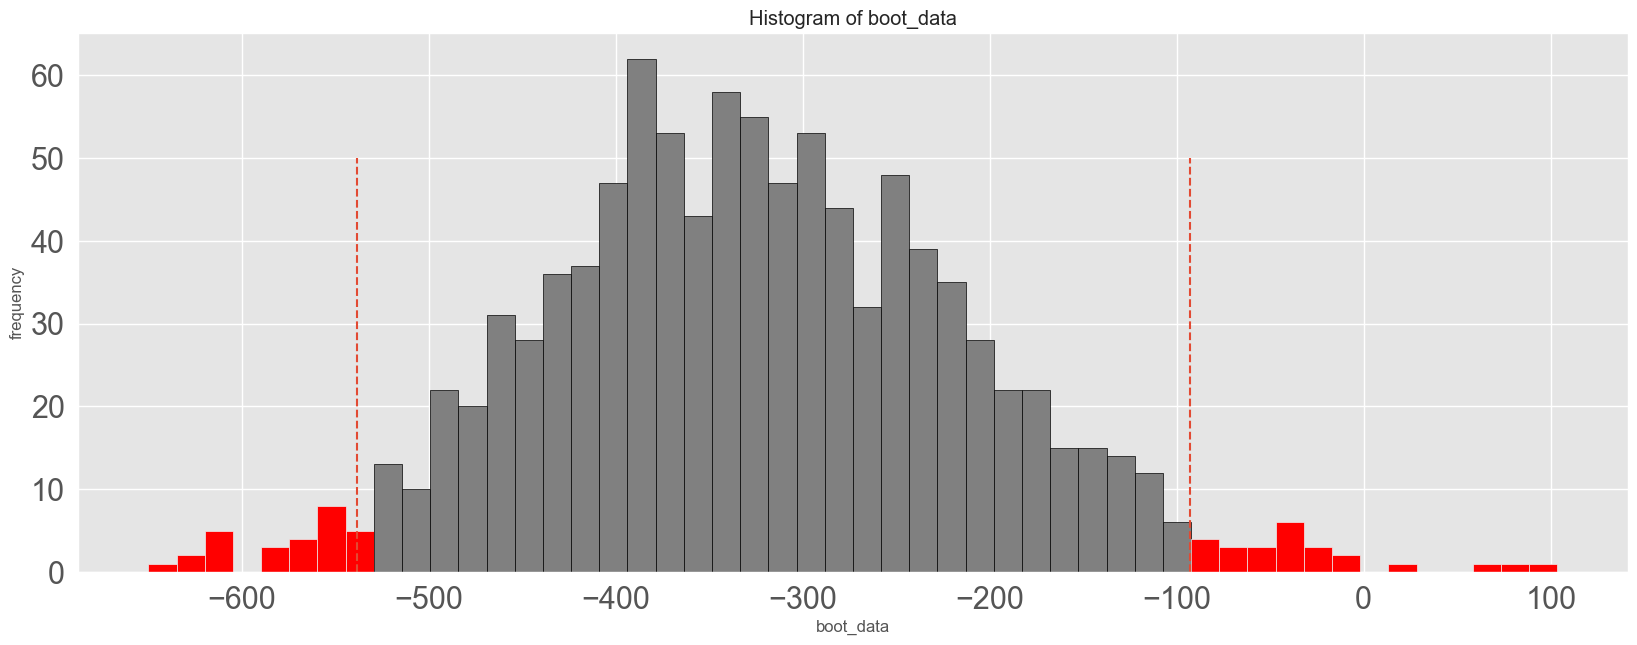

{'p_value': 0.004554806127687592}

In [50]:
get_bootstrap(
    paid_studs_a['rev'], # числовые значения первой выборки
    paid_studs_b['rev'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Как и ранее тут история немного другая, p-value значительно меньше уровня 0,05 и в среднем чеке есть стат. значимые различия. Ну и проверим средний доход от пользователя, хотя вряд ли мы увидим что-то новое

In [51]:
paid_studs_arpu_1 = groups.merge(paid_studs, how = 'left', on = ['id', 'grp']) 
paid_studs_arpu_1

,id,grp,rev
0,1489,B,NaN
1,1627,A,990.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN
...,...,...,...
74571,200247820,B,NaN
74572,201032527,B,NaN
74573,201067612,B,NaN
74574,201067653,B,NaN


In [52]:
paid_studs_arpu = paid_studs_arpu_1.fillna(0)

paid_studs_arpu_a = paid_studs_arpu.query('grp=="A"')

paid_studs_arpu_b = paid_studs_arpu.query('grp=="B"')

  0%|          | 0/1000 [00:00<?, ?it/s]

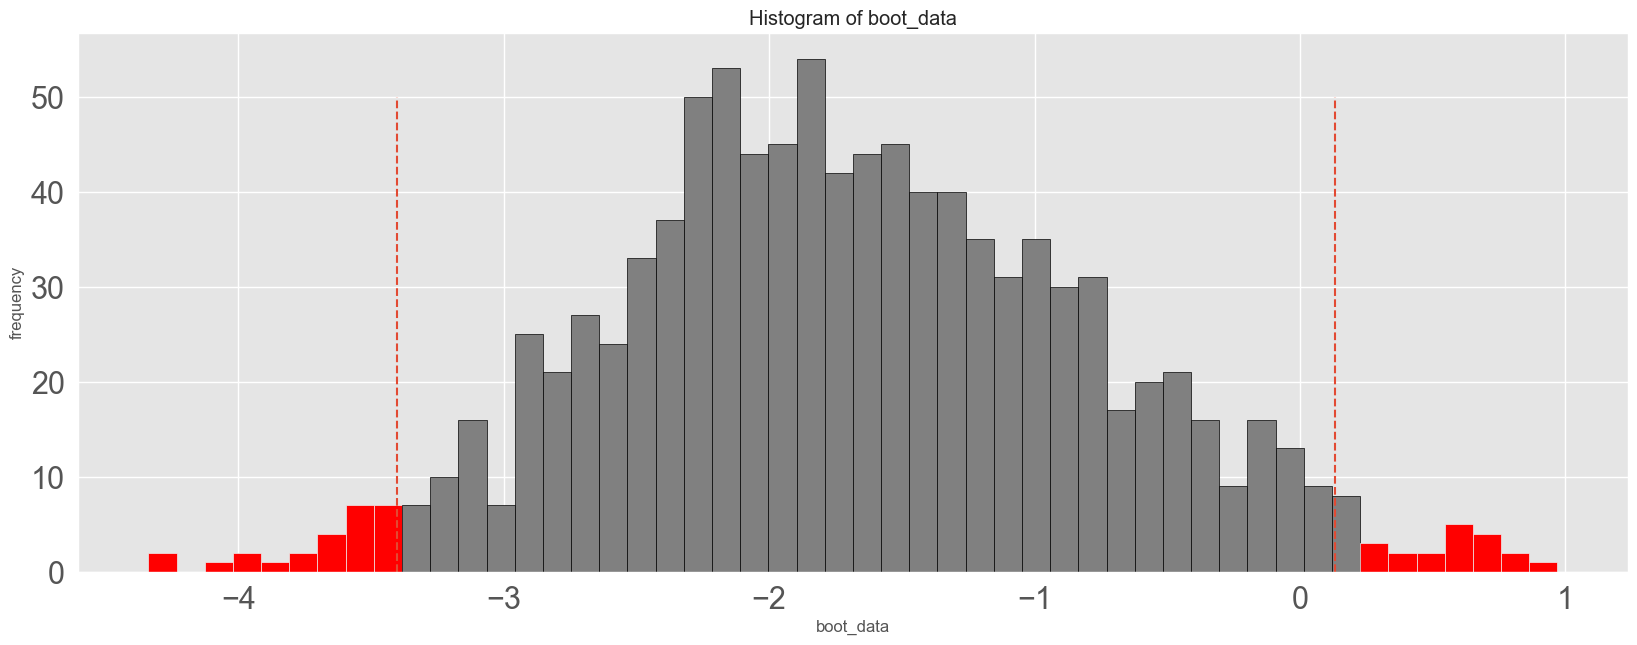

{'p_value': 0.06308924100812809}

In [53]:
get_bootstrap(
    paid_studs_arpu_a['rev'], # числовые значения первой выборки
    paid_studs_arpu_b['rev'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

# Вывод:

Мы провели стат. анализ а/б-тестирования новой механики оплаты услуг на сайте. В первом случае мы оценивали первичные данные, во втором добавли еще новую таблицу к данным.

Также посмотрели как пользователи разбиты по группам, и выяснилось, что в группах значимо отличается чило пользователей, примерно в 4 раза, на это стоит обратить внимание, так как это достаточно странно. Также рапредение среднего чека по гистограммам и в соответствии с методом Шапиро-Уилкса распределение ненормальное.

Также судя по описательной статитстике и графикам распределений для контрольной группы около 75% чеков менее 1100, но в тестовой группе возможно случился некоторый сбой и 50% чеков превышают порог в 1000, разработчикам стоит обратить на это внимание и выяснить с чем связан такой рост.

Оцениваемые метрики: CR, avg check, ARPU, ARPPU. первые две метрики являются базовыми в бизнесе, поэтому при проведенеии   а/б теста их необходимо обязательно рассчитать и сравнить, 3 и 4 метрики я выбрала на основе полученных данных, то есть  имея кол-во пользователей, клиентов и их доход мы можем оценитть эти метрики, но рассчитать что-то другое мы не можем из-за недостаточности сведений.

Различия в метриках на первый взгляд есть, значения отличаются, но не сильно, чтобы оценить значимое ли это различие мы будем проводить стат. тесты

Для оценки различий в конверсии был примене метод хи-квадрат Пирсона, так как конверсия это категориальная переменная (пользователь либо совершил покупку, либо нет). По полученным данным мы не смогли отклонить нулевую гипотезы об отсутствии стат. значимых различий в группах для конверсии.

Для оценки среднего чека, ARPU  был применен бустрап, так как распределение ненормальное и проблемы с размером групп А и В. Метод бустрап для ср. чека показал наличие стат. значимых различий при данных условиях, а для ARPU наоборот. 

Эти результаты аналогичны и после добавления новой таблицы.

Судя по полученным результатам следует либо провести а/б тест заново, но уже корректно:
* выяснить причины такого роста в чеках в тестовой группе,
* оценить еще раз размер выборки для теста (общее кол-во пользователей) и выяснить, в связи с чем такие различия в группах, 
* оценить, откуда появились клиенты, которые не были активными пользователями.

В том случае, если при новых условиях не будет получено стат. значимых различий, то необходимо разработать либо новый дизайн окна оплаты или разработать новые методы, которые могут увелить конверсию и средний чек, и на них уже проводить а/б тестирование.

## Задание 2. SQL

#### 2.1 Очень усердные ученики.

##### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

###### 2.1.2 Задача
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

#### 2.2 Оптимизация воронки

##### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

##### 2.2.2 Задача
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
* ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [54]:
#импортируем нужные либы
import pandahouse as ph
import pandas as pd

In [55]:
#объявляем параметры подключения
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

В задание указано про 20 заданий, но есть ученики, которые решили более 20 заданий за указанный период, их также включим 
в таблицу, нижу будет представлена таблица с количеством учеников, которые решили 20 заданий
Также в представленной таблице указаны данные за 30-31 марта 2021г

In [56]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT
    min(cast(timest as Date)) as min_timest,
    max(cast(timest as Date)) as max_timest
    
FROM default.peas
"""
min_max_time = ph.read_clickhouse(query, connection=connection)
min_max_time

,min_timest,max_timest
0,2021-10-30,2021-10-31


In [57]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT
    DISTINCT count(st_id) as count_stud --количество учеников, выполнивших не менее 20 заданий
FROM
(SELECT
    count(correct) as count_task, --количество выполненных заданий с группировкой по ученикам
    st_id
FROM default.peas
WHERE 
    correct=1
GROUP BY st_id
    )
WHERE 
    count_task>=20
"""
count_task = ph.read_clickhouse(query, connection=connection)
count_task

,count_stud
0,136


In [58]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT
    DISTINCT count(st_id) as count_stud --количество учеников, выполнивших не менее 20 заданий
FROM
(SELECT
    count(correct) as count_task, --количество выполненных заданий с группировкой по ученикам
    st_id
FROM default.peas
WHERE 
    correct=1
GROUP BY st_id
    )
WHERE 
    count_task=20
"""
count_task_20 = ph.read_clickhouse(query, connection=connection)
count_task_20

,count_stud
0,6


In [59]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe 2.2
query = """
WITH all_data as (
    SELECT 
        c.st_id as st_id,
        c.sum_corr as sum_corr,
        c.sum_corr_math as sum_corr_math,
        c.sum_money as sum_money,
        c.sum_money_math as sum_money_math,
        d.test_grp as test_grp
    FROM
        (SELECT
            b.st_id as st_id,
            b.sum_corr as sum_corr,
            b.sum_corr_math as sum_corr_math,
            a.sum_money as sum_money,
            a.sum_money_math as sum_money_math
        FROM 
            (SELECT 
                st_id,
                sum(money) as sum_money,
                sum(CASE WHEN subject = 'Math' THEN money END) as sum_money_math
            FROM default.final_project_check
            GROUP BY st_id) as a
        FULL JOIN 
            (SELECT 
                st_id,
                sum(correct) as sum_corr,
                sum(CASE WHEN subject = 'Math' THEN correct END) as sum_corr_math
            FROM default.peas   
            GROUP BY st_id) as b 
        ON a.st_id = b.st_id) as c
    LEFT JOIN default.studs  as d
    ON c.st_id = d.st_id
    ),
    users as (
    SELECT count(DISTINCT st_id) as all_users, test_grp
    FROM default.studs
    GROUP BY test_grp
    )
SELECT 
    test_grp,
    sum(sum_money)/all_users as ARPU,
    sum(sum_money)/count(CASE WHEN sum_corr>10 THEN st_id END) as ARPAU,
    count(CASE WHEN sum_money>0 THEN st_id END)/all_users as CR,
    count(CASE WHEN (sum_money>0 and sum_corr>10) THEN st_id END)/count(CASE WHEN sum_corr>10 THEN st_id END) as CR_active,
    count(CASE WHEN (sum_money_math>0 and sum_corr_math>1) THEN st_id END)/count(CASE WHEN sum_corr_math>1 THEN st_id END) as CR_math_act
FROM  users, all_data
WHERE all_data.test_grp=users.test_grp
GROUP BY  test_grp, all_users

"""
metrics = ph.read_clickhouse(query, connection=connection)
metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math_act
0,control,4540.983607,10905.511811,0.049180,0.110236,0.061224
1,pilot,11067.796610,34010.416667,0.101695,0.260417,0.095238


#### Задание 3. Python
##### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [60]:
#Функция, которая пересчитывает метрики
def get_new_metrics(
    data_new, #новая таблица (groups_add.csv)
    data_groups, #существующая таблица с группами
    data_active,
    data_checks):
    data_new = group_add.rename(columns={group_add.columns[1]:groups.columns[1],
                                        group_add.columns[0]:groups.columns[0]}) #измненяем название колонок
    data_groups = groups.merge(data_new, how = 'outer', on = [groups.columns[0], groups.columns[1]]).fillna(0)  
    #объединяем сущ таблицу и новую
    
    data_active = data_groups.merge(studs, how = 'inner', on = data_groups.columns[0]) #объединяем таблицу с таблицей 
    #активных пользователей
    
    data_paid_studs = data_active.merge(checks, how = 'inner', on = studs.columns[0]) #объединяем таблицу с таблицей 
    #оплативших пользователей
    
    data_paid_groups = data_groups.merge(checks, how = 'left', on = data_groups.columns[0]) #объединяем таблицу с группами 
    #оплативших пользователей
    
    data_grp_paid = data_groups.merge(data_paid_studs, how = 'left', on = [data_groups.columns[0], data_groups.columns[1]])
    #объединяем тадлицы для расчетов
    
    #проводим расчеты
    data_a = data_grp_paid.groupby(data_grp_paid.columns[1], as_index = False)\
        .agg({data_grp_paid.columns[2]:'sum', data_grp_paid.columns[0]:'count'})\
        .rename(columns = {data_grp_paid.columns[0]:'users'})
    
    data_b = data_paid_studs.groupby(data_paid_studs.columns[1], as_index = False)\
        .agg({data_paid_studs.columns[0]:'count'})\
        .rename(columns = {data_paid_studs.columns[0]:'clients'})
    
    data = data_a.merge(data_b, how = 'inner', on = data_a.columns[0])
    
    data_count_checks = data_grp_paid.groupby([data_groups.columns[1], data_groups.columns[0]], as_index = False)\
        .agg({data_grp_paid.columns[2]:'count'})\
        .groupby(data_groups.columns[1], as_index = False)\
        .agg({data_grp_paid.columns[2]:'sum'})\
        .rename(columns = {data_grp_paid.columns[2]:'count_checks'})
    
    data = data.merge(data_count_checks, how = 'inner', on = data.columns[0])
    
    data['CR'] = round(data.clients / data.users * 100, 4)
    data['av_ch'] = data.rev / data.clients
    data['ARPPU'] = data.count_checks / data.clients * data.av_ch
    data['ARPU'] = data.ARPPU * data.CR
    
    return (data)


In [61]:
get_new_metrics(
    group_add, #новая таблица (groups_add.csv)
    groups, #существующая таблица с группами
    studs,
    checks)

,grp,rev,users,clients,count_checks,CR,av_ch,ARPPU,ARPU
0,A,72820.0000,14693,78,78,0.5309,933.589744,933.589744,495.642795
1,B,394974.0035,59883,314,314,0.5244,1257.878992,1257.878992,659.631743


In [62]:
df_for_gr = df.drop(columns={'sum_rev', 'users', 'clients', 'count_checks', 'active'})
df_for_gr

,grp,CR,av_ch,ARPPU,ARPU
0,A,5.0814,933.589744,933.589744,4.963534
1,B,4.6077,1255.827487,1255.827487,6.571715


In [63]:
df_new_for_gr = df_new
for i in [1, 2, 3, 4, 5]: #для начала преобразуем наши жанные для построения графиков
    df_new_for_gr = df_new_for_gr\
    .rename(columns={df_new_for_gr.columns[i+4]:(df_new_for_gr.columns[i+4]+'_with_new_table')})
    
df_new_for_gr = df_new_for_gr\
    .drop(columns={df_new_for_gr.columns[1], df_new_for_gr.columns[2], 
                   df_new_for_gr.columns[3], df_new_for_gr.columns[4], df_new_for_gr.columns[5]})
df_new_for_gr

,grp,CR_with_new_table,av_ch_with_new_table,ARPPU_with_new_table,ARPU_with_new_table
0,A,5.0715,933.589744,933.589744,4.956102
1,B,4.6156,1257.878992,1257.878992,6.595762


In [64]:
#Функция для построения графиков
def get_plot(df, df_new):
    plt.figure(figsize=(85, 65))
    plt.rc('xtick', labelsize=70)
    plt.rc('ytick', labelsize=70)
    plt.subplot(2, 2, 1)
    plt.suptitle('Изменение первичное и после добавления корректировочных данных', fontsize=80)

    # Построение графика
    plt.plot(df.grp, df.CR, 
             df_new.grp, df_new.CR_with_new_table, 
             linewidth = 10)
    plt.legend(['CR', 'CR_with_new_table'], fontsize=70)
    
    plt.subplot(2, 2, 2)
        # Построение графика
    plt.plot(df.grp, df.ARPU, 
             df_new.grp, df_new.ARPU_with_new_table, 
             linewidth = 10) 
    plt.legend(['ARPU', 'ARPU_with_new_table'], fontsize=70)

    plt.subplot(2, 2, 3)
    # Построение графика
    plt.plot(df.grp, df.av_ch, 
             df_new.grp, df_new.av_ch_with_new_table, 
             linewidth = 10) 
    plt.legend(['average_check', 'average_check_with_new_table'], fontsize=70)

    plt.subplot(2, 2, 4)
    # Построение графика
    plt.plot(df.grp, df.ARPPU, 
             df_new.grp, df_new.ARPPU_with_new_table, 
             linewidth = 10) 
    plt.legend(['ARPPU', 'ARPPU_with_new_table'], fontsize=70)

    

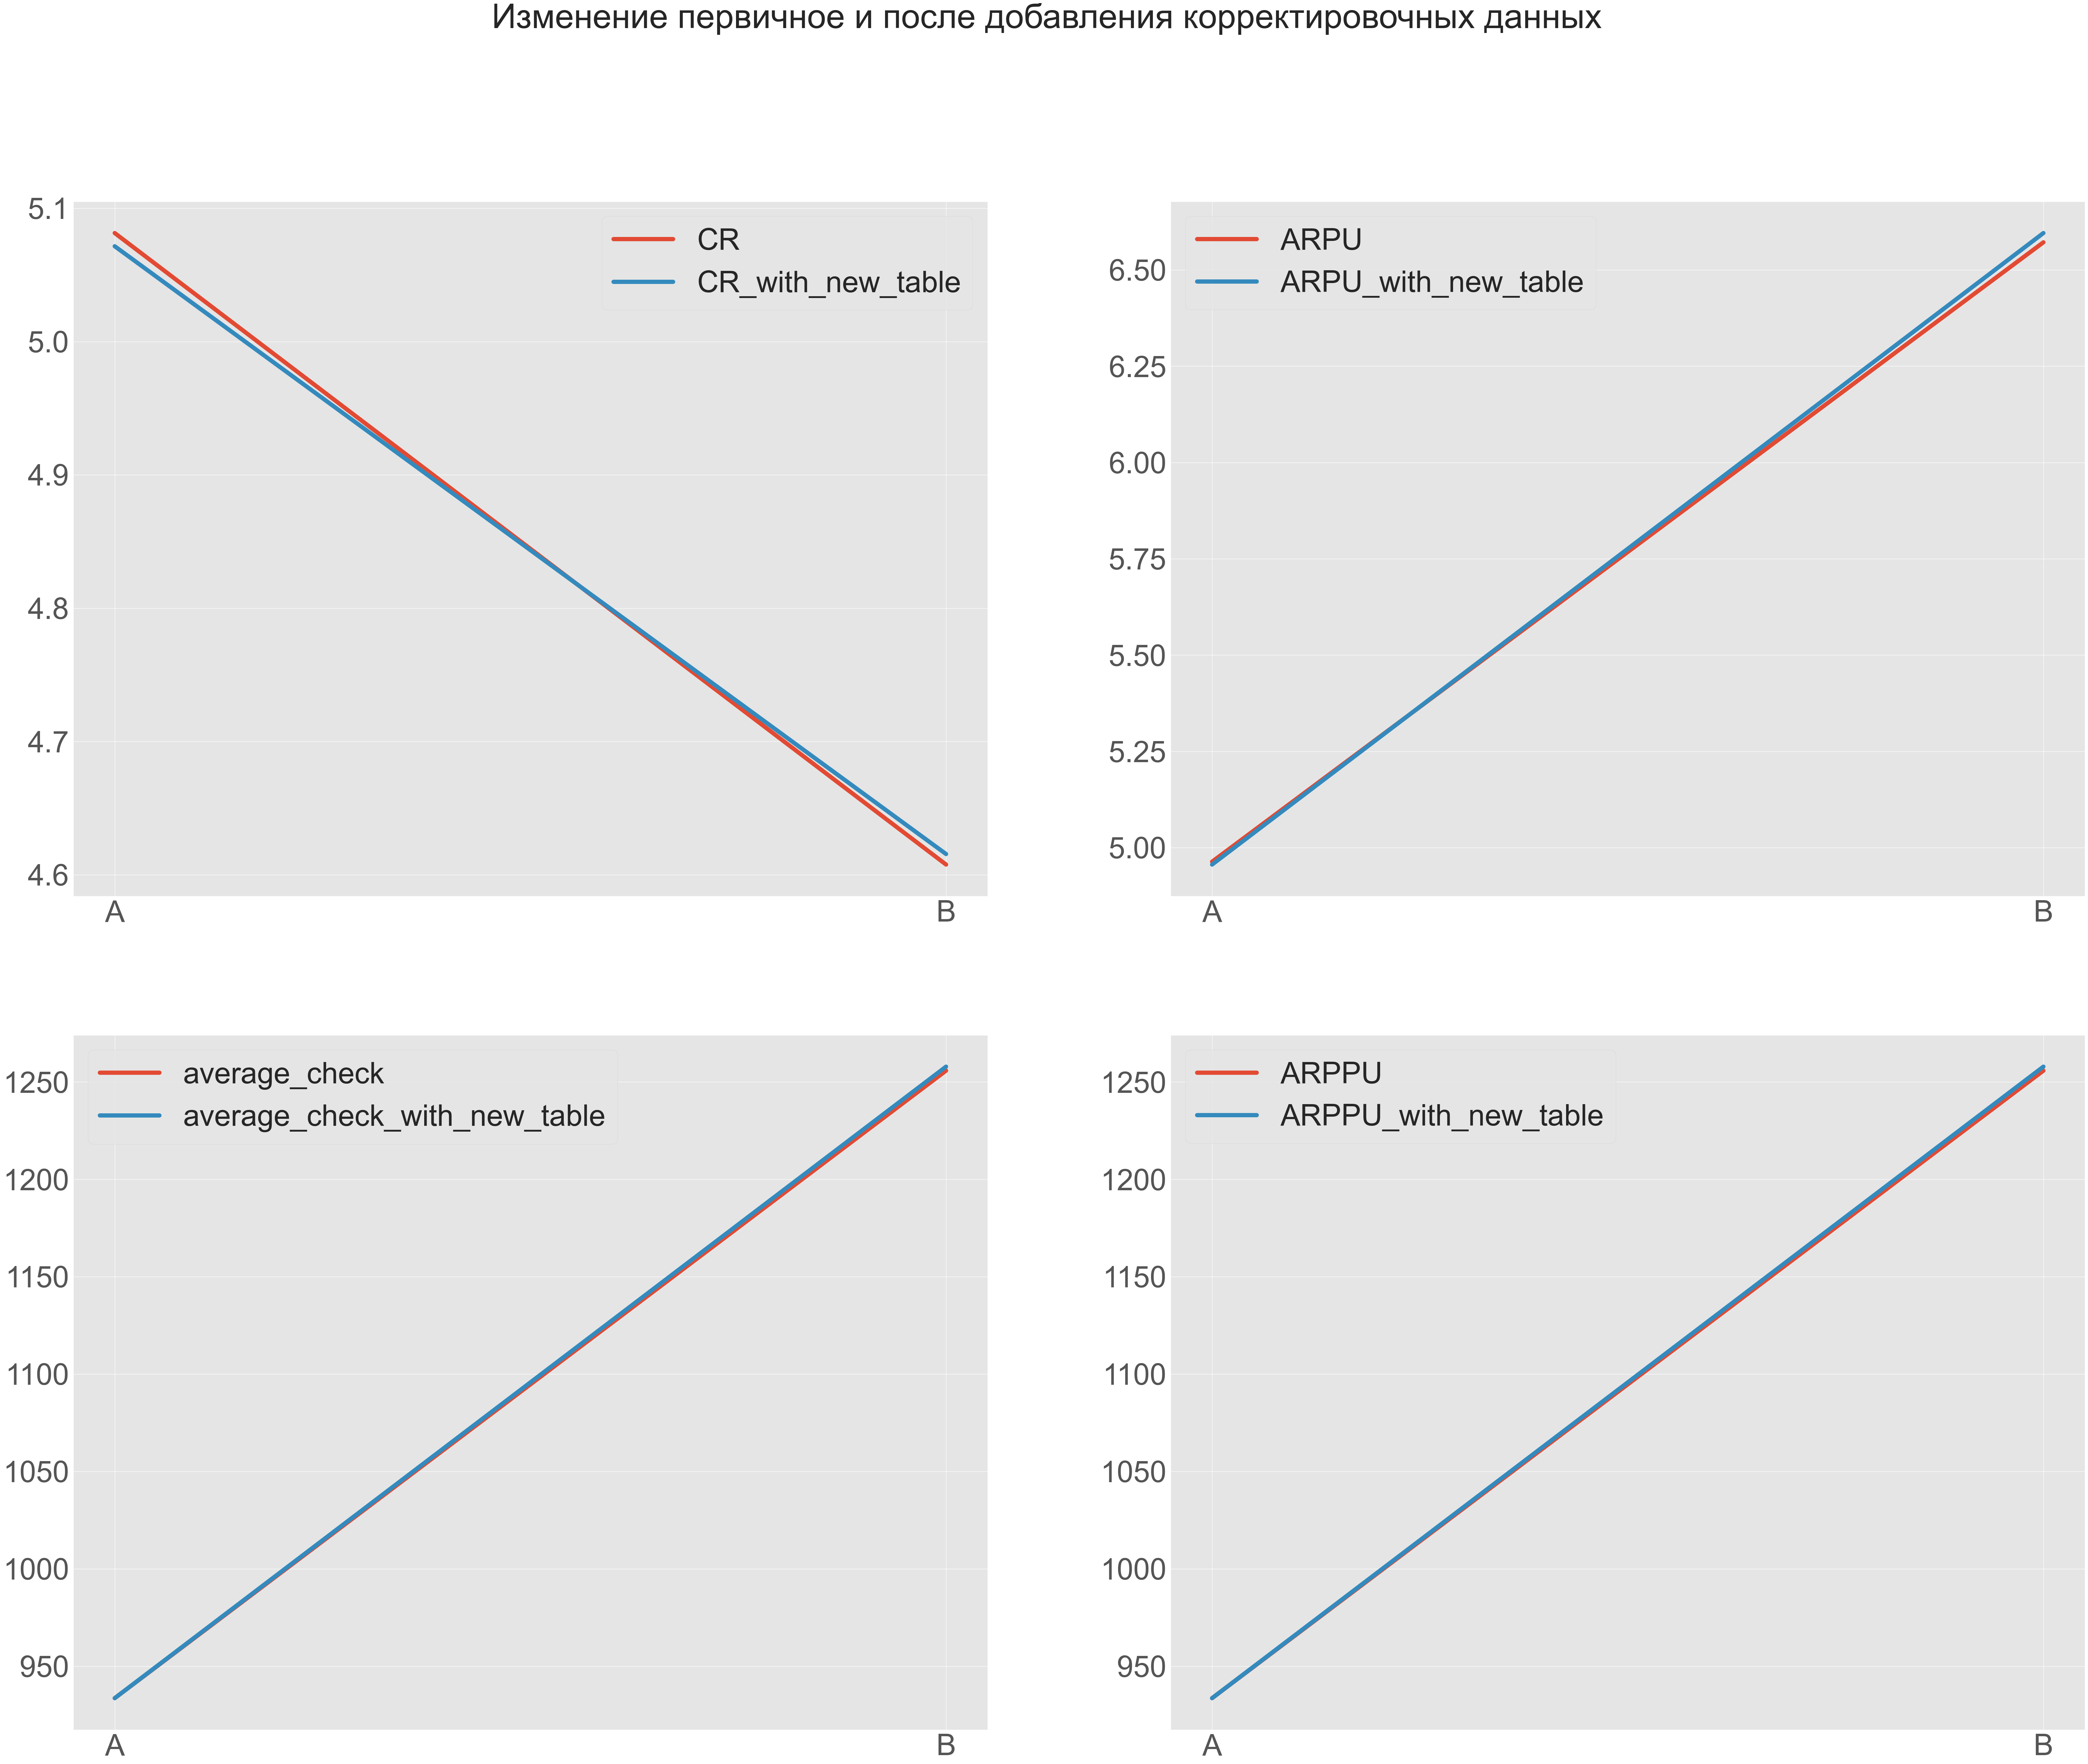

In [65]:
get_plot(df_for_gr, df_new_for_gr)